# Only Fine Structure (Movre Pischler) Reorganized

## Setup

In [22]:
import sys
sys.path.append("..")
import numpy as np
np.set_printoptions(precision=3,suppress=True,linewidth=100000, edgeitems=10000)
from sympy.physics.quantum.cg import CG
import matplotlib.font_manager
import pandas as pd
import math
from matplotlib.patches import FancyArrowPatch
import scipy.linalg
import IPython.display
import matplotlib.pyplot as plt
import Analysis_Python_Files.Constants as mc
import Analysis_Python_Files.Miscellaneous as misc
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

import matplotlib.style
import matplotlib as mpl
import copy
# matplotlib.style.use('default')
pd.set_option("max_colwidth", 200)
from importlib import reload
import time
import Analysis_Python_Files.MoleculeCalculation as mol
import Analysis_Python_Files.CollisionalAnalysis as lac
import matplotlib.patches as patches
import pandas as pd

In [2]:
reload(lac)

<module 'Analysis_Python_Files.CollisionalAnalysis' from '/Users/stevenpampel/Documents/B232_Data_Analysis/Molecular_Potentials/../Analysis_Python_Files/CollisionalAnalysis.py'>

# Calculation

In [23]:
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = mol.createAtomicBases([0,1], [1/2], [0])

In [24]:
E_HFS_5S12_F1F2 = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
E_HFS_5P12_F1F2 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
E_FS_5P12_5P32 = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h

transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
C_3_val_alt = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h

C_3_val = mc.Rb87_C3
print(E_FS_5P12_5P32, C_3_val)
print("From first principles one can calculate C3 to be: ", C_3_val_alt, "but this differs from the literature value which is: ", C_3_val)

4.7197635548748796e-21 5.94492796981645e-48
From first principles one can calculate C3 to be:  5.774794407751793e-48 but this differs from the literature value which is:  5.94492796981645e-48


In [25]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [26]:
fsOperator_unitless = mol.create_H_FS(jiBasis2Atom)
lsToJOp2 = mol.create_lsi2ToJi2_Op(lsiBasis2Atom,jiBasis2Atom)
fsOperator = fsOperator_unitless * 2 * DeltaVal / 3

## Create Symmetrized Fine Structure Hamiltonians

In [27]:
expandedBOBasis = mol.addFsRelevantStates(mol.boStates)
for state in expandedBOBasis:
    print(state)

{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': -1, '|Omega|': 0}
{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 1, 'kappa_FS': 1, '|Omega|': 1}
{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'u', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': -1, '|Omega|': 0}
{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'u', 'kappa_BO': 1, '|Sigma|': 1, 'kappa_FS': 1, '|Omega|': 1}
{'L': 1, '|Lambda|': 0, 'S': 0, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0}
{'L': 1, '|Lambda|': 0, 'S': 0, 'I_BO': 'u', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0}
{'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', 'kappa_BO': '', '|Sigma|': 1, 'kappa_FS': -1, '|Omega|': 0}
{'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', 'kappa_BO': '', '|Sigma|': 1, 'kappa_FS': 1, '|Omega|': 0}
{'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', 'kappa_BO': '', '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 1}
{'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', 'kappa_BO': '', '|Sigm

In [28]:
for state in expandedBOBasis: # to work with hfs code
    state.update({'L':1,'|Iota|':0,'I':0,'i_a':0,'i_b':0,'|Phi|':state['|Omega|'], 'kappa_HFS':state['kappa_FS']})

In [29]:
totalSpatialParityIncluded = ['a','b']
symmetrizedBases = {}
for Omega in [0,1,2]:
    for state in expandedBOBasis:
        if math.isclose(state['|Omega|'], Omega):
            if Omega == 0:
                parityString = '+' if state['kappa_FS'] == 1 else '-'
            else:
                parityString = ''
            symmetryLabel = str(Omega) + parityString + state['I_BO']
            if symmetryLabel not in symmetrizedBases:
                symmetrizedBases[symmetryLabel] = []
            symmetrizedBases[symmetryLabel].append(state)

for label,state in symmetrizedBases.items():           
    print(label,state)

0-g [{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': -1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': -1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', 'kappa_BO': '', '|Sigma|': 1, 'kappa_FS': -1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': -1}]
0-u [{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'u', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': -1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': -1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'u', 'kappa_BO': '', '|Sigma|': 1, 'kappa_FS': -1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': -1}]
0+g [{'L': 1, '|Lambda|': 0, 'S': 0, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', 'kappa_BO': '', '|Sigma|': 1, 'kappa_FS': 1, '|Omega|': 0, '|Iota

### calculate H_fs

In [30]:
reload(mol)
caseAMostlySymHfs = mol.createCaseABasis_MostlySym([1],[0,1], [0], I_BOvals=['g', 'u'])
H_fs_phi, H_hfs_phi = {}, {}
#for label, base in {**symmetrizedBases, **mostlySymmetrizedBases}.items():
for label, base in symmetrizedBases.items():
    # print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    # print(label,base)
    #caseAToLsi = mol.genCaseAToLsiTransform(base, lsiBasis, caseAMostlySymHfs, basisChange=None).T
    caseAToLsi = mol.genCaseAToLsiTransform2(base, lsiBasis2Atom, caseAMostlySymHfs).T
    caseAToJi =  lsToJOp2 @ caseAToLsi
    H_fs_phi[label] = caseAToJi.T @ fsOperator @ caseAToJi + np.identity(len(base))*(-1/2* 2 * E_FS_5P12_5P32 / 3)

In [31]:
for label, matrix in H_fs_phi.items():
    print('\033[1m' +label+'\033[0m \n', matrix*1e21)

0-g 
 [[-1.573  2.225]
 [ 2.225 -3.147]]
0-u 
 [[-1.573  2.225]
 [ 2.225 -3.147]]
0+g 
 [[-1.573 -2.225]
 [-2.225 -3.147]]
0+u 
 [[-1.573 -2.225]
 [-2.225 -3.147]]
1g 
 [[-1.573  1.573  1.573]
 [ 1.573 -1.573 -1.573]
 [ 1.573 -1.573 -1.573]]
1u 
 [[-1.573  1.573  1.573]
 [ 1.573 -1.573 -1.573]
 [ 1.573 -1.573 -1.573]]
2g 
 [[0.]]
2u 
 [[0.]]


## Results

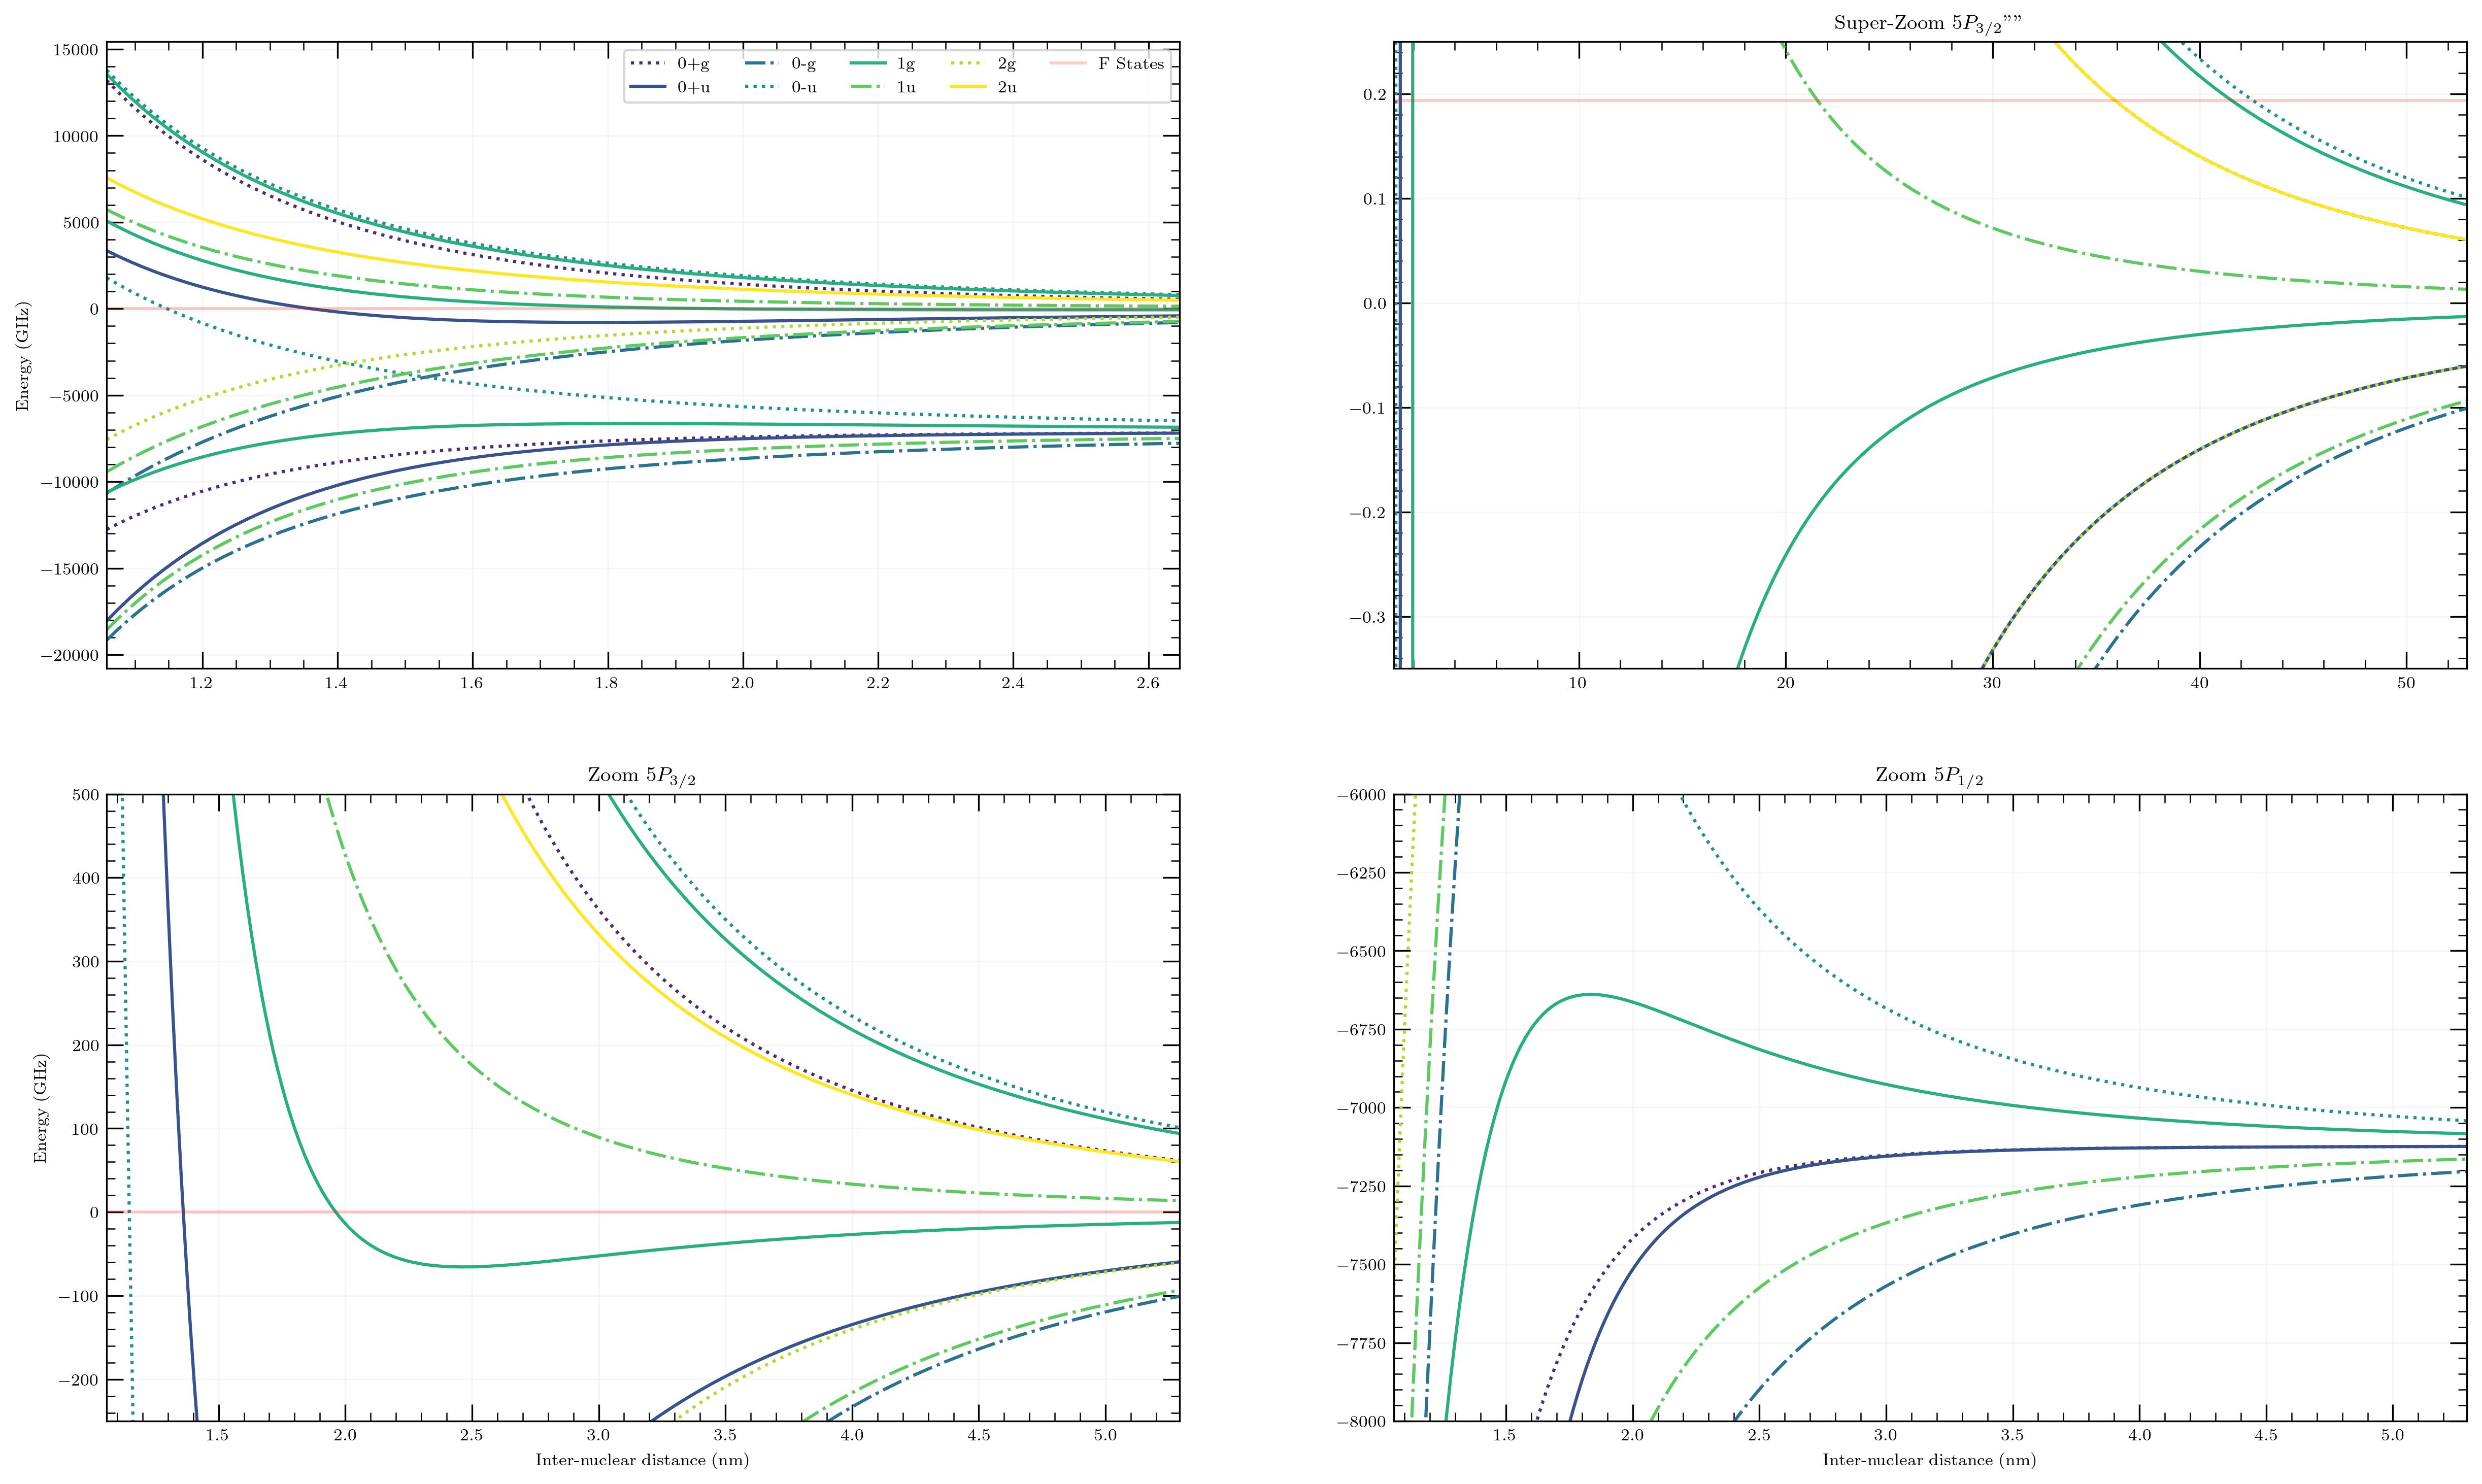

In [15]:
mpl.rcParams['figure.dpi']=300
fig, axs = plt.subplots(2,2,figsize=(20,12))
Rvals = np.linspace( 20 * mc.a0, 1000 * mc.a0, 3000 )
linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
allBases = {**symmetrizedBases }
colors, _ = misc.getColors(len(allBases), cmStr='viridis')
data = {}
for basisNum, (label, basis) in enumerate(allBases.items()):
    #for matrixnum, (name, potentialMatrix, c_, boStates) in enumerate(zip(names, potentialList, colors, BohrOppenheimerStates)):
    for rv in Rvals:
        rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float) + H_fs_phi[label]
        #rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float)
        #rMatrix = createBOMatrix(C_3_val, rv, *boStates).astype(float) + potentialMatrix * 2 * DeltaVal / 3
        if label not in data:
            data[label]=[]
        data[label].append(sorted(np.linalg.eigvals(rMatrix)))
        
for ax in axs.flatten():
    if False:
        ax.axhline(-0.0729113, alpha=0.2,color='r')
        ax.axhline(-0.2298518, alpha=0.2,color='r')
        ax.axhline(-0.30207388, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
    
    for num, label in enumerate(data.keys()):
        mdata = data[label]
        linestyle = linestyles[num]
        c_ = colors[num]
        if len(np.array(mdata).shape) == 2 or len(np.array(mdata).shape) == 3:
            for lineNum, lineData in enumerate(misc.transpose(mdata)):
                ax.plot(Rvals*1e9, np.array(lineData) * 1e-9 / mc.h, 
                        label=label if lineNum == 0 else None, color=c_, linestyle=linestyle)
        else:
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, 
                    label=name, color=c_, linestyle=linestyle)
    
    #ax.set_xlabel('Inter-nuclear distance (nm)')
    #ax.set_ylabel('Energy (GHz)')
    ax.grid(alpha=0.1)
    ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

axs[1,0].set_xlabel('Inter-nuclear distance (nm)')
axs[1,1].set_xlabel('Inter-nuclear distance (nm)')
axs[0,0].set_ylabel('Energy (GHz)')
axs[1,0].set_ylabel('Energy (GHz)')
axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
axs[0,0].legend(ncol=5,fontsize=8)
axs[1,0].set_title('Zoom $5P_{3/2}$')
axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,0].set_ylim(-250, 500)
axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
axs[0,1].set_ylim(-0.35, 0.25)
axs[1,1].set_title('Zoom $5P_{1/2}$')
axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,1].set_ylim(-8000, -6000);
# axs[0,0].plot(Rvals*1e9,3/2*cs.Rb87_C3/Rvals**3/(cs.h*1e9),linewidth=3,color='black')
# axs[1,0].plot(Rvals*1e9,3/2*cs.Rb87_C3/Rvals**3/(cs.h*1e9),linewidth=3,color='black')
# axs[0,1].plot(Rvals*1e9,3/2*cs.Rb87_C3/Rvals**3/(cs.h*1e9),linewidth=3,color='black')
# axs[1,1].plot(Rvals*1e9,3/2*cs.Rb87_C3/Rvals**3/(cs.h*1e9)-delta,linewidth=3,color='black')

#plt.savefig('Movre-Pischler.png', dpi=200)www

In [40]:
reload(mol)

<module 'Analysis_Python_Files.MoleculeCalculation' from '/Users/stevenpampel/Documents/B232_Data_Analysis/Molecular_Potentials/../Analysis_Python_Files/MoleculeCalculation.py'>

In [32]:
allBases = {**symmetrizedBases}
data = {}
for basisNum, (label, basis) in enumerate(allBases.items()):
    print(basis)
    rMatrix = mol.get_H_BO(1, 1, basis) #+ H_fs_unsym[label]*1e21
    print('\033[1m' +label+'\033[0m \n', rMatrix)

[{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': -1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': -1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', 'kappa_BO': '', '|Sigma|': 1, 'kappa_FS': -1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': -1}]
0-g 
 [[-2.  0.]
 [ 0.  1.]]
[{'L': 1, '|Lambda|': 0, 'S': 1, 'I_BO': 'u', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': -1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': -1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'u', 'kappa_BO': '', '|Sigma|': 1, 'kappa_FS': -1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': -1}]
0-u 
 [[ 2.  0.]
 [ 0. -1.]]
[{'L': 1, '|Lambda|': 0, 'S': 0, 'I_BO': 'g', 'kappa_BO': 1, '|Sigma|': 0, 'kappa_FS': 1, '|Omega|': 0, '|Iota|': 0, 'I': 0, 'i_a': 0, 'i_b': 0, '|Phi|': 0, 'kappa_HFS': 1}, {'L': 1, '|Lambda|': 1, 'S': 1, 'I_BO': 'g', 'kappa_BO': '', '|S

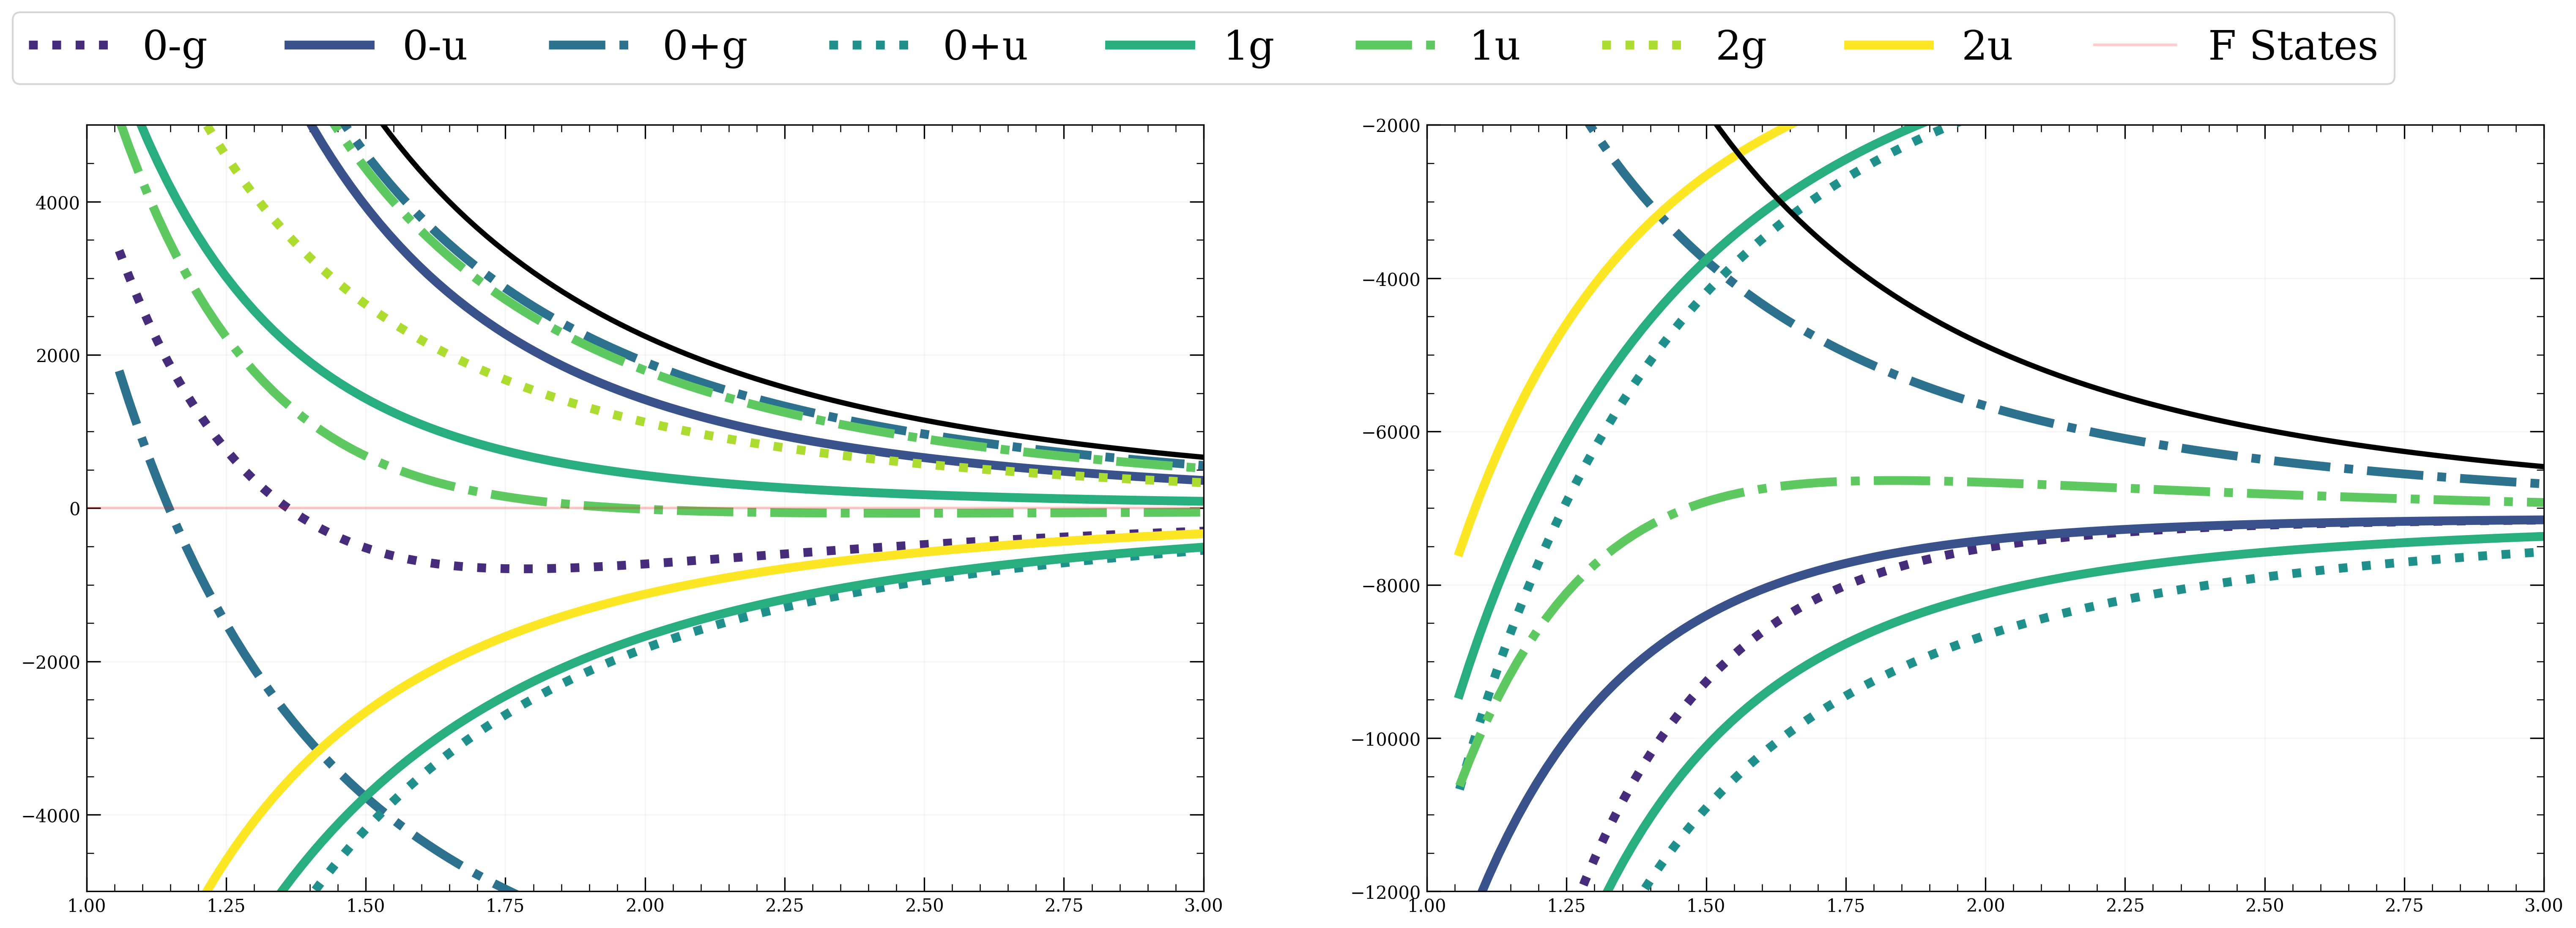

In [39]:
mpl.rcParams['figure.dpi']=300
fig, axs = plt.subplots(1,2,figsize=(25,8))
Rvals = np.linspace( 20 * mc.a0, 1000 * mc.a0, 3000 )
linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
allBases = {**symmetrizedBases }
colors, _ = misc.getColors(len(allBases), cmStr='viridis')
data = {}
for basisNum, (label, basis) in enumerate(allBases.items()):
    #for matrixnum, (name, potentialMatrix, c_, boStates) in enumerate(zip(names, potentialList, colors, BohrOppenheimerStates)):
    for rv in Rvals:
        rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float) + H_fs_phi[label]
        #rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float)
        #rMatrix = createBOMatrix(C_3_val, rv, *boStates).astype(float) + potentialMatrix * 2 * DeltaVal / 3
        if label not in data:
            data[label]=[]
        data[label].append(sorted(np.linalg.eigvals(rMatrix)))
        
for ax in axs.flatten():
    if False:
        ax.axhline(-0.0729113, alpha=0.2,color='r')
        ax.axhline(-0.2298518, alpha=0.2,color='r')
        ax.axhline(-0.30207388, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
    
    for num, label in enumerate(data.keys()):
        mdata = data[label]
        linestyle = linestyles[num]
        c_ = colors[num]
        if len(np.array(mdata).shape) == 2 or len(np.array(mdata).shape) == 5:
            for lineNum, lineData in enumerate(misc.transpose(mdata)):
                ax.plot(Rvals*1e9, np.array(lineData) * 1e-9 / mc.h, 
                        label=label if lineNum == 0 else None, color=c_, linestyle=linestyle,linewidth=5)
        else:
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, 
                    label=name, color=c_, linestyle=linestyle,linewidth=5)
    
    #ax.set_xlabel('Inter-nuclear distance (nm)')
    #ax.set_ylabel('Energy (GHz)')
    ax.grid(alpha=0.1)
    ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')


axs[0].set_xlim(1,3)
axs[0].set_ylim(-5000, 5000)
axs[0].legend(ncol=9, fontsize=23, bbox_to_anchor=[1,1.1], loc='center')

axs[1].set_xlim(1,3)
axs[1].set_ylim(-12000, -2000)
axs[0].plot(Rvals*1e9,2*mc.Rb87_C3/Rvals**3/(mc.h*1e9),linewidth=3,color='black')
axs[1].plot(Rvals*1e9,2*mc.Rb87_C3/Rvals**3/(mc.h*1e9)-E_FS_5P12_5P32/(mc.h*1e9),linewidth=3,color='black')
# axs[0,1].plot(Rvals*1e9,3/2*cs.Rb87_C3/Rvals**3/(cs.h*1e9),linewidth=3,color='black')
# axs[1,1].plot(Rvals*1e9,3/2*cs.Rb87_C3/Rvals**3/(cs.h*1e9)-delta,linewidth=3,color='black')

#plt.savefig('Movre-Pischler.png', dpi=200)www